# Left ventricle segmentation

Here we use a nnU-Net segmentation model trained on the [augmented CAMUS](https://arxiv.org/abs/2502.20100) dataset within the zea framework to segment the left ventricle and myocardium in apical two and four chamber views.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/left_ventricle_segmentation_example2.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/left_ventricle_segmentation_example2.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/gillesvdv/augmented_camus_seg)
&nbsp;
[![arXiv](https://img.shields.io/badge/arXiv-Paper-b31b1b.svg)](https://arxiv.org/abs/2502.20100)

In [1]:
%%capture
%pip install zea
%pip install onnxruntime

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
from keras import ops

from zea import init_device
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.visualize import plot_image_grid, set_mpl_style

init_device(verbose=False)
set_mpl_style()

E0000 00:00:1759173284.758136   17761 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759173284.762164   17761 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759173284.775051   17761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759173284.775066   17761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759173284.775068   17761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759173284.775069   17761 computation_placer.cc:177] computation placer already registered. Please check linka

zea: Using backend 'tensorflow'


### Load segmentation onnx model

In [3]:
from zea.models.lv_segmentation import AugmentedCamusSeg

INFERENCE_SIZE = 256
model = AugmentedCamusSeg()
# load weights from huggingface
model.custom_load_weights()

Now let's load some data (for more info see the [zea_data_example](../data/zea_data_example.ipynb) notebook), and perform inference on the data to segment the left ventricle.

In [4]:
# Arqee contains a helper function for visualization of segmentation masks
!pip install git+https://github.com/GillesVanDeVyver/arqee

  Cloning https://github.com/GillesVanDeVyver/arqee to /tmp/pip-req-build-qxedemnu
  Running command git clone --filter=blob:none --quiet https://github.com/GillesVanDeVyver/arqee /tmp/pip-req-build-qxedemnu
  Resolved https://github.com/GillesVanDeVyver/arqee to commit 36a5352bb8cc211ad035bdd9dce2e3b44d4a95fa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import numpy as np
import arqee

n_imgs = 16
val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image_sc",
    batch_size=n_imgs,
    shuffle=True,
    image_range=[-45, 0],
    clip_image_range=True,
    normalization_range=[-1, 1],
    image_size=(INFERENCE_SIZE, INFERENCE_SIZE),
    resize_type="resize",
    seed=42,
)

batch = next(iter(val_dataset))
batch_np = ops.convert_to_numpy(batch)

# ONNX expects NCHW: (batch, channels, depth, width)
onnx_input = np.transpose(batch_np, (0, 3, 1, 2))

outputs = model.call(onnx_input)

outputs = np.array(outputs)
# predicted class = class with the highest score for each pixel
masks = np.argmax(outputs, axis=1)

fig, _ = plot_image_grid(masks, vmin=0, vmax=1)
axes = fig.axes[:n_imgs]
for ax, mask, us_image in zip(axes, masks, batch_np):
    visual = arqee.create_visualization(us_image[:, :, -1], mask, labels=[1, 2])
    ax.imshow(visual)

plt.tight_layout()
plt.savefig("augmented_camus_seg_output.png", dpi=200)
plt.close(fig)

zea: Using pregenerated dataset info file: /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on September 29, 2025
zea: Remove /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.


I0000 00:00:1759173308.835565   17761 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43500 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:01:00.0, compute capability: 8.9


zea: H5Generator: Shuffled data.


/tmp/ipykernel_17761/31151495.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


![nnU-Net](./augmented_camus_seg_output.png)

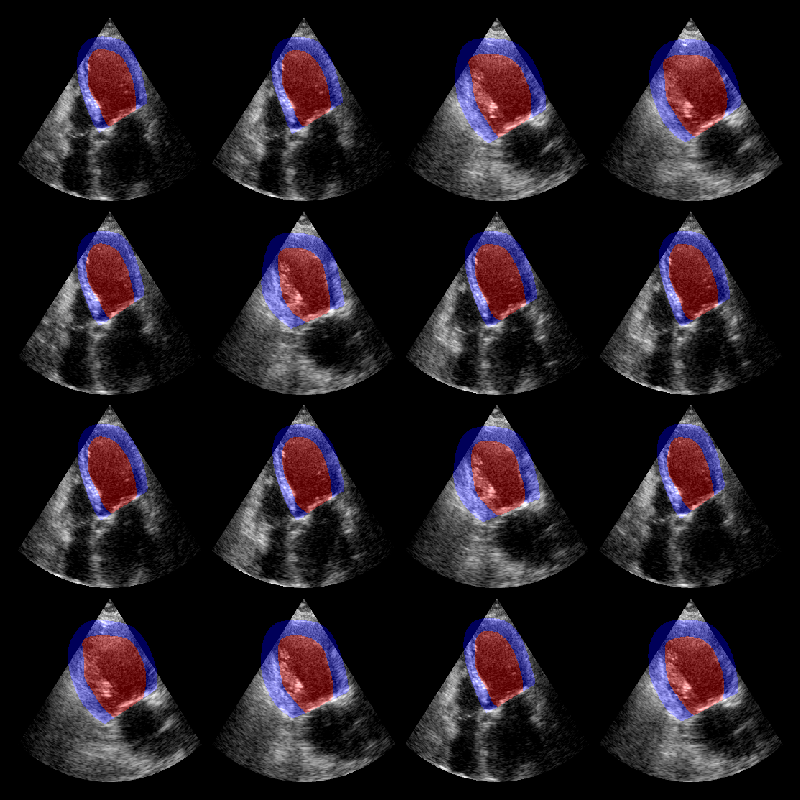